## SSFP simualtions in 2D
###### Author: Zimu Huo
###### Date: 02.2022


The tissue parameter maps are generated for CSF and FAT in a series of T1, T2, proton density maps 
and the results are generated pixel by pixel in an iterative manner. 
For more details, check references 2 as the following code is only a crude representation of the ideas from the original author. 

Special thanks to Neal and Michael for sending me the resources 

-------------------------------------------------------------------------
References
    
    [1] 
    Author: Dr Neal K Bangerter
    Title: Contrast enhancement and artifact reduction in steady state magnetic resonance imaging
    Link: https://www.proquest.com/openview/41a8dcfb0f16a1289210b3bd4f9ea82b/1.pdf?cbl=18750&diss=y&pq-origsite=gscholar
    
    [2] 
    Author: Michael A. Mendoza
    Title: Water Fat Separation with Multiple Acquisition Balanced Steady State Free Precession MRI
    Link: https://scholarsarchive.byu.edu/cgi/viewcontent.cgi?article=5303&context=etd
         
         

    


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from simulator.bSSFP import *
import numpy.matlib
import matplotlib.cm as cm
from matplotlib.colors import LightSource, Normalize

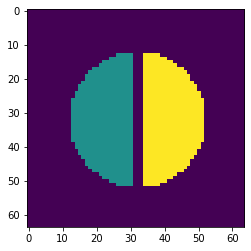

In [2]:
height = 64
width = 64
rsq = 20
tissue_map = np.zeros([height, width])
for y in range(height):
    for x in range(width):
        if ((x-32)**2+(y-32)**2) < rsq**2:
            if(x < 31):
                tissue_map[y, x] = 0.5
            if(x > 33):
                tissue_map[y, x] = 1
plt.figure()
plt.imshow(tissue_map)
plt.show()

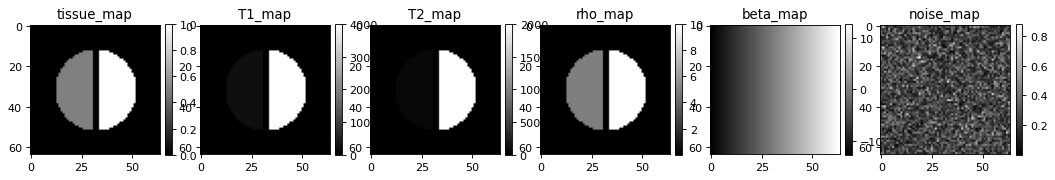

In [3]:
# Michael section 3.2 page 20
EPSILON = 0.00000001
# data for T1 and T2
# https://mri-q.com/why-is-t1--t2.html
T1_CSF = 4000
T2_CSF = 2000
T1_FAT = 250
T2_FAT = 70

T1_map = np.zeros([height, width]) + EPSILON
T1_map[tissue_map > 0.5] = T1_CSF
T1_map[tissue_map == 0.5] = T1_FAT
T2_map = np.zeros([height, width]) + EPSILON
T2_map[tissue_map > 0.5] = T2_CSF
T2_map[tissue_map == 0.5] = T2_FAT

beta_map = np.zeros([height, width])
beta = np.linspace(-4*np.pi, 4*np.pi, height)
beta_map = np.matlib.repmat(beta, width, 1)

noise_map = np.zeros([height, width], dtype=complex)
noise_map.real = np.random.normal(0, 0.2, 64*64).reshape(64, 64)
noise_map.imag = np.random.normal(0, 0.2, 64*64).reshape(64, 64)

# data for proton density
# http://www.paul-tofts-phd.org.uk/CV/reprints/A14_c04_pd.pdf
CSF_rho = 10
FAT_rho = 5
rho_map = np.zeros([height, width]) + EPSILON
rho_map[tissue_map > 0.5] = CSF_rho
rho_map[tissue_map == 0.5] = FAT_rho
plt.figure(figsize=(16, 12), dpi=80)
ax1 = plt.subplot(161)
tf1 = plt.imshow(tissue_map, cmap='gray')
plt.title("tissue_map")
plt.colorbar(tf1, fraction=0.046, pad=0.04)
ax2 = plt.subplot(162)
tf2 = plt.imshow(T1_map, cmap='gray')
plt.title("T1_map")
plt.colorbar(tf2, fraction=0.046, pad=0.04)
ax3 = plt.subplot(163)
tf3 = plt.imshow(T2_map, cmap='gray')
plt.title("T2_map")
plt.colorbar(tf3, fraction=0.046, pad=0.04)
ax4 = plt.subplot(164)
tf4 = plt.imshow(rho_map, cmap='gray')
plt.title("rho_map")
plt.colorbar(tf4, fraction=0.046, pad=0.04)
plt.subplot(165)
tf5 = plt.imshow(beta_map, cmap="gray")
plt.colorbar(tf5, fraction=0.046, pad=0.04)
plt.title("beta_map")
plt.subplot(166)
tf6 = plt.imshow(np.abs(noise_map), cmap="gray")
plt.colorbar(tf6, fraction=0.046, pad=0.04)
plt.title("noise_map")
plt.show()

In [4]:
image = np.zeros([height, width], dtype=complex)
for y in range(height):
    for x in range(width):
        alpha = np.pi/4
        Nr = 100
        T1 = T1_map[y, x]
        T2 = T2_map[y, x]
        TR = 10
        TE = TR/2
        M0 = np.asarray(
            [noise_map[y, x].real, noise_map[y, x].imag, rho_map[y, x]])
        phi = 0
        dphi = 0
        beta = beta_map[y, x]
        image[y, x] = vectorform_SSFP(
            M0=M0, alpha=alpha, phi=phi, dphi=dphi, beta=beta, TR=TR, TE=TE, T1=T1, T2=T2, Nr=Nr)

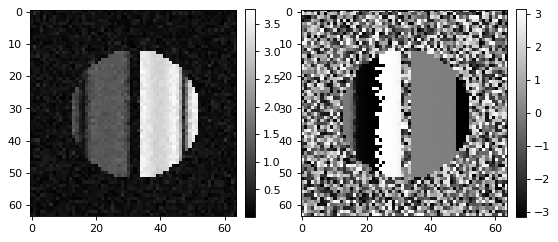

In [5]:
plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(121)
tf5 = plt.imshow(np.absolute(image), cmap='gray')
plt.colorbar(tf5, fraction=0.046, pad=0.04)
ax = plt.subplot(122)
tf7 = plt.imshow(np.angle(image), plt.cm.gray)
plt.colorbar(tf7, fraction=0.046, pad=0.04)
plt.show()
# left FAT right CSF